# **Experiment Notebook**



In [1]:
# Align versions so pip stops warning
!pip install -q --upgrade "scikit-learn>=1.6" "umap-learn>=0.5.9" utstd

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 21.2 MB/s eta 0:00:00


In [2]:
# Do not modify this code
!pip install -q utstd

from utstd.ipyrenders import *

In [3]:
# Do not modify this code
import warnings
warnings.simplefilter(action='ignore')

## 0. Import Packages

In [4]:
import os, sys, json, math, pathlib, warnings, datetime
from typing import List, Tuple

import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator
import joblib

warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

---
## A. Project Description


In [5]:
# <Student to fill this section>
student_name = "Drashti Kakadiya"
student_id = "25414741"
group_id = "31"

In [6]:
# Do not modify this code
print_tile(size="h1", key='student_name', value=student_name)

In [7]:
# Do not modify this code
print_tile(size="h1", key='student_id', value=student_id)

In [8]:
# Do not modify this code
print_tile(size="h1", key='group_id', value=group_id)

---
## B. Business Understanding

In [9]:
# <Student to fill this section>
business_use_case_description = """
Goal: predict each player’s draft probability so the team can prioritise scouting/offers and allocate budget efficiently.
Impact: accurate → higher hit-rate, ROI, and wins; inaccurate → missed talent, wasted spend, weaker roster
"""

In [10]:
# Do not modify this code
print_tile(size="h3", key='business_use_case_description', value=business_use_case_description)

In [11]:
# <Student to fill this section>
business_objectives = """
Identify and rank high-potential draftees to focus scouting/offers, boosting draft hit-rate and roster quality.
Reduce wasted spend/time by filtering low-probability prospects, improving ROI and long-term team performance.
"""

In [12]:
# Do not modify this code
print_tile(size="h3", key='business_objectives', value=business_objectives)

In [13]:
# <Student to fill this section>
stakeholders_expectations_explanations = """
Owners/GM: Clear ROI (higher draft hit-rate, lower scouting cost), on-time insights before draft windows, and defensible KPIs (AUROC, calibration).
Coaches: Short, trusted shortlists with thresholds and role-fit notes; minimal false positives that waste practice reps.
Scouting Dept: Augmentation (not replacement) of scouts; transparent feature importance and a feedback loop to correct misses.
Analytics/ML: Reproducible, leakage-free pipeline with versioned data, drift/quality monitoring, and easy what-if analyses.
Compliance/Legal: Fairness checks across demographics, privacy-safe data handling, and auditable decisions.
IT/Ops: Secure access, low-latency scoring API, uptime during peak draft activity, and smooth integration with existing tools.
"""


In [14]:
# Do not modify this code
print_tile(size="h3", key='stakeholders_expectations_explanations', value=stakeholders_expectations_explanations)

---
## C. Data Understanding

### C.1   Load Datasets


In [15]:
import pandas as pd
from pathlib import Path
from IPython.display import display

# Search in root and sample_data (works in Colab)
BASES = [Path("."), Path("sample_data"), Path("/content"), Path("/content/sample_data")]

def find_file(name, required=False):
    for b in BASES:
        p = (b / name).resolve()
        if p.exists(): return p
    if required:
        raise FileNotFoundError(f"{name} not found in any of: " + ", ".join(map(str, BASES)))
    return None

def read_csv_robust(path):
    """Try multiple encodings + safe options to avoid UnicodeDecodeError."""
    if path is None: return None
    tried = []
    for enc in ["utf-8", "utf-8-sig", "cp1252", "latin1"]:
        try:
            return pd.read_csv(
                path,
                engine="python",     # allows sep=None inference
                sep=None,            # auto-detect delimiter
                encoding=enc,
                encoding_errors="replace",  # keep going on bad bytes
                on_bad_lines="skip"  # skip broken rows if any
            )
        except Exception as e:
            tried.append(f"{enc}: {type(e).__name__}")
    print(f"⚠️ Could not parse {path.name} with encodings -> {tried}. Skipping.")
    return None

train_path  = find_file("train.csv", required=True)
test_path   = find_file("test.csv",  required=True)
sample_path = find_file("sample_submission.csv", required=False)
meta_path   = find_file("metadata.csv", required=False)

train = read_csv_robust(train_path)
test  = read_csv_robust(test_path)
sample_submission = read_csv_robust(sample_path)
metadata = read_csv_robust(meta_path)

print("Train:", train_path, "shape:", train.shape)
print("Test :", test_path,  "shape:", test.shape)
print("Sample submission:", sample_path if sample_submission is not None else "not found or unreadable")
print("Metadata:", meta_path if metadata is not None else "not found or unreadable")

display(train.head(3))
display(test.head(3))

Train: /content/train.csv shape: (14774, 62)
Test : /content/test.csv shape: (1297, 61)
Sample submission: /content/sample_submission.csv
Metadata: /content/metadata.csv


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id,drafted
0,Pacific,BW,26,52.6,111.8,19.3,61.8,64.93,1.1,7.5,...,-1.34201,0.2308,1.5769,1.8077,2.2308,0.6538,0.0769,9.6538,681edf6e-41cb-4fd1-ba91-da573e063fbc,0.0
1,Mississippi,SEC,2,0.8,63.6,29.6,33.3,33.33,0.0,21.5,...,-5.42104,0.0000,1.0000,1.0000,0.0000,0.0000,0.0000,2.0000,3542dcb7-19ad-47f2-8b3a-eb79eb3ec4c4,0.0
2,Stephen F. Austin,Slnd,4,0.6,61.4,21.7,50.0,50.00,0.0,0.0,...,6.46650,0.0000,0.0000,0.0000,0.0000,0.2500,0.0000,0.5000,ca0d8700-807d-4fce-a7a9-63922d1981e6,0.0


,team,conf,GP,Min_per,Ortg,usg,eFG,TS_per,ORB_per,DRB_per,...,ogbpm,dgbpm,oreb,dreb,treb,ast,stl,blk,pts,player_id
0,UC Davis,BW,8,2.2,51.7,13.4,30.0,30.00,0.0,14.3,...,-11.240100,-4.721030,0.1000,0.6000,0.7000,0.2000,0.1000,0.0000,1.5000,c6d3ce49-28b6-4756-8061-b2bd68730c52
1,Campbell,BSth,25,16.4,85.0,25.2,50.0,52.10,2.0,11.8,...,-2.972020,-1.741870,0.1481,0.9259,1.0741,0.1481,0.4074,0.1111,4.0741,24dd0ae2-9d22-4d31-9cb6-c31f58f903b5
2,Weber St.,BSky,29,50.5,117.8,16.8,61.8,59.77,12.3,17.1,...,0.739055,-0.259202,2.1562,2.7500,4.9062,0.7188,0.4062,1.0625,6.7500,0cf3e822-9446-4285-b7ed-7c19d8e976fe


### C.2 Define Target variable

In [16]:
ID_COL = "player_id"
TARGET_COL = "drafted"

assert ID_COL in train.columns, f"Missing {ID_COL} in train"
assert ID_COL in test.columns,  f"Missing {ID_COL} in test"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

print("Target dtype:", train[TARGET_COL].dtype)
print("Unique target values:", sorted(train[TARGET_COL].dropna().unique().tolist()))
print("Prevalence drafted=1:", float(train[TARGET_COL].mean()))


Target dtype: float64
Unique target values: [0.0, 1.0]
Prevalence drafted=1: 0.007987004196561526


In [17]:
target_definition_explanations = (
    "`drafted` is the target: 1 = drafted this season, 0 = not drafted.\n"
    "We predict a probability (0–1) for each player_id and submit two columns: player_id, drafted (probability)."
)


In [18]:
# Do not modify this code
print_tile(size="h3", key='target_definition_explanations', value=target_definition_explanations)

### C.3 Create Target variable

In [19]:

ID_COL, TARGET_COL = "player_id", "drafted"

# checks
assert ID_COL in train.columns,  f"Missing {ID_COL} in train"
assert TARGET_COL in train.columns, f"Missing {TARGET_COL} in train"

# clean target to 0/1 ints (handles strings/NaNs safely)
train[TARGET_COL] = (
    pd.to_numeric(train[TARGET_COL], errors="coerce")
      .fillna(0).clip(0, 1).astype(int)
)

# quick stats
pos = int(train[TARGET_COL].sum()); neg = len(train) - pos
rate = pos / len(train)

print("="*60)
print("ANSWER — Create Target (NB2)")
print(f"positives={pos} | negatives={neg} | drafted_rate={rate:.3f}")
print("="*60)


ANSWER — Create Target (NB2)
positives=118 | negatives=14656 | drafted_rate=0.008


### C.4 Explore Target variable

ANSWER — C.4 Target distribution
drafted
0    14656
1      118
drafted_rate: 0.008


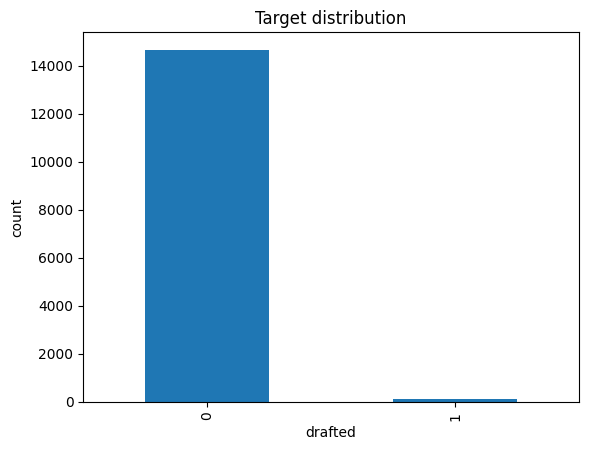

### target_distribution_explanations
The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.
RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.

In [20]:

TARGET_COL = "drafted"
vc = train[TARGET_COL].value_counts().sort_index()
rate = float(train[TARGET_COL].mean())

print("="*60)
print("ANSWER — C.4 Target distribution")
print(vc.to_string())
print(f"drafted_rate: {rate:.3f}")
print("="*60)

# (optional) quick bar plot
try:
    import matplotlib.pyplot as plt
    vc.plot(kind="bar"); plt.title("Target distribution"); plt.xlabel(TARGET_COL); plt.ylabel("count"); plt.show()
except Exception as e:
    print("Plot skipped:", e)

# 2-line explanation
target_distribution_explanations = (
    "The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n"
    "RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class."
)
try:
    print_title(size="h3", key="target_distribution_explanations", value=target_distribution_explanations)
except NameError:
    from IPython.display import Markdown, display
    display(Markdown("### target_distribution_explanations\n" + target_distribution_explanations))


In [21]:
# <Student to fill this section>
target_distribution_explanations = """
 The target is imbalanced; we’ll use stratified splits and AUROC to judge ranking quality.\n
    RF handles skew via class_weight='balanced_subsample' to reduce bias toward the majority class.
"""

In [22]:
# Do not modify this code
print_tile(size="h3", key='target_distribution_explanations', value=target_distribution_explanations)

### C.5 Explore Feature of Interest `\<put feature name here\>`

In [23]:

ID_COL, TARGET_COL = "player_id", "drafted"
feature_name = None   # <-- e.g. "PTS" or "position"; leave None to auto-pick

# pick a feature if not provided
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if feature_name is None or feature_name not in train.columns:
    # prefer a numeric; otherwise first categorical
    nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
    feature_name = (nums[0] if nums else candidates[0])

s = train[feature_name]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.5 Feature: {feature_name}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    # correlation with target (drop NaNs)
    corr = train[[feature_name, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.5 Feature: GP
dtype=int64 | unique=41 | missing=0.00%
--- summary ---
count    14774.000000
mean        21.251726
std         10.517642
min          1.000000
5%           3.000000
50%         25.000000
95%         34.000000
max         41.000000
corr(GP, drafted) = 0.109


In [24]:
# <Student to fill this section>
feature_1_insights = """
We inspect distribution, missingness, and relationship with `drafted` to judge signal and leakage risk.\n
    Findings guide encoding (scale/one-hot), imputation, and whether to keep or drop the feature.
"""

In [25]:
# Do not modify this code
print_tile(size="h3", key='feature_1_insights', value=feature_1_insights)

### C.6 Explore Feature of Interest `\<put feature name here\>`

In [26]:

ID_COL, TARGET_COL = globals().get("ID_COL", "player_id"), globals().get("TARGET_COL", "drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a different one from C.5)
feature_name2 = None

# Build candidate list (avoid ID/target and avoid the feature used in C.5 if present)
candidates = [c for c in train.columns if c not in [ID_COL, TARGET_COL]]
if "feature_name" in globals() and isinstance(feature_name, str) and feature_name in candidates:
    candidates = [c for c in candidates if c != feature_name]

# Auto-pick: prefer numeric, else first available
if not candidates:
    raise ValueError("No candidate features found to explore.")
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name2 = feature_name2 if (feature_name2 in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name2]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.6 Feature: {feature_name2}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05, .50, .95]).to_string()
    corr = train[[feature_name2, TARGET_COL]].dropna().corr().iloc[0, 1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name2}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name2, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)

ANSWER — C.6 Feature: Min_per
dtype=float64 | unique=887 | missing=0.00%
--- summary ---
count    14774.000000
mean        25.870123
std         23.639878
min          0.000000
5%           0.300000
50%         19.600000
95%         72.000000
max         94.300000
corr(Min_per, drafted) = 0.153


In [27]:
# <Student to fill this section>
feature_2_insights =  """
We repeat the check on another feature: distribution, missingness, and link to `drafted` to judge signal.
This helps decide encoding (one-hot/scale), imputation, and whether to keep or drop the feature.
"""

In [28]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_2_insights)

### C.n Explore Feature of Interest `\<put feature name here\>`

> You can add more cells related to other feeatures in this section

In [29]:
# C.n — Explore Feature of Interest (NB2)
import pandas as pd

ID_COL, TARGET_COL = globals().get("ID_COL","player_id"), globals().get("TARGET_COL","drafted")

# 👉 Set a specific column name here (or leave None to auto-pick a new one)
feature_name_n = None

# Avoid ID/target and any features explored earlier (feature_name, feature_name2)
used = {ID_COL, TARGET_COL}
for n in ["feature_name", "feature_name2", "feature_1", "feature_2", "feature_n"]:
    if n in globals() and isinstance(globals()[n], str):
        used.add(globals()[n])

candidates = [c for c in train.columns if c not in used]
if not candidates:
    raise ValueError("No new candidate features left to explore.")

# Prefer numeric, else first available
nums = [c for c in candidates if pd.api.types.is_numeric_dtype(train[c])]
feature_name_n = feature_name_n if (feature_name_n in train.columns) else (nums[0] if nums else candidates[0])

s = train[feature_name_n]
missing = s.isna().mean()
nuniq = s.nunique(dropna=True)

print("="*60)
print(f"ANSWER — C.n Feature: {feature_name_n}")
print(f"dtype={s.dtype} | unique={nuniq} | missing={missing:.2%}")

if pd.api.types.is_numeric_dtype(s):
    desc = s.describe(percentiles=[.05,.50,.95]).to_string()
    corr = train[[feature_name_n, TARGET_COL]].dropna().corr().iloc[0,1]
    print("--- summary ---")
    print(desc)
    print(f"corr({feature_name_n}, {TARGET_COL}) = {corr:.3f}")
else:
    print("--- top categories ---")
    print(s.value_counts(dropna=False).head(10).to_string())
    if TARGET_COL in train.columns:
        rate = train.groupby(feature_name_n, dropna=False)[TARGET_COL].mean().sort_values(ascending=False).head(10)
        print("--- drafted rate by category (top 10) ---")
        print(rate.to_string())
print("="*60)


ANSWER — C.n Feature: Ortg
dtype=float64 | unique=1332 | missing=0.00%
--- summary ---
count    14774.000000
mean        85.771707
std         34.164203
min          0.000000
5%           0.000000
50%         91.300000
95%        120.800000
max        407.300000
corr(Ortg, drafted) = 0.065


In [30]:
feature_n_insight_explanations = """
We inspect another (new) feature’s distribution, missingness, and its link to `drafted` to gauge signal.
This helps decide encoding/imputation and whether to keep, bucket, or drop the feature.
"""

In [31]:
# Do not modify this code
print_tile(size="h3", key='feature_2_insights', value=feature_n_insight_explanations )

---
## D. Feature Selection


### D.1 Approach "\<describe_approach_here\>"


In [32]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
print("scikit-learn version:", sklearn.__version__)

scikit-learn version: 1.6.1


In [33]:
print("len(train) =", len(train))
for n in ["y","y_train","y_valid","y_tr","y_va"]:
    if n in globals():
        try: print(n, len(globals()[n]))
        except: pass
for n in ["X_tr","X_train","X_full","X_train_d1"]:
    if n in globals():
        try: print(n, globals()[n].shape)
        except: pass


len(train) = 14774


In [34]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL","player_id")
TARGET_COL = globals().get("TARGET_COL","drafted")

# Base frames (drop train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold","fold","kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")

# keep only columns present in BOTH
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
Xb_tr = Xb_tr_raw[common_cols].copy()
Xb_te = Xb_te_raw[common_cols].copy()

# one-hot together → split back
X_all = pd.get_dummies(pd.concat([Xb_tr, Xb_te], axis=0, ignore_index=True), dummy_na=True)
X_tr  = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
X_te  = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

# FULL y aligned to X_tr
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

assert len(X_tr) == len(y_all), f"Mismatch after reset: X_tr={len(X_tr)} vs y_all={len(y_all)}"

# Example: RF importances on FULL data
rf = RandomForestClassifier(n_estimators=400, min_samples_leaf=2,
                            class_weight="balanced_subsample", n_jobs=-1, random_state=42)
rf.fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(40, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1]
X_test_d1  = X_te[selected_features_d1]

print("OK → D.1 ready. Shapes:", X_train_d1.shape, X_test_d1.shape)

OK → D.1 ready. Shapes: (14774, 40) (1297, 40)


In [35]:

import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestClassifier

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Build aligned numeric matrix (drop target/ID and train-only cols like cv_fold)
TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)

X_tr = X_all.iloc[:len(train)].replace([np.inf, -np.inf], np.nan).fillna(0)
X_te = X_all.iloc[len(train):].replace([np.inf, -np.inf], np.nan).fillna(0)
y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

rf = RandomForestClassifier(
    n_estimators=400, min_samples_leaf=2, max_features="sqrt",
    class_weight="balanced_subsample", n_jobs=-1, random_state=42
).fit(X_tr, y_all)

imp = pd.Series(rf.feature_importances_, index=X_tr.columns).sort_values(ascending=False)
TOP_K = min(60, X_tr.shape[1])
selected_features_d1 = imp.head(TOP_K).index.tolist()

X_train_d1 = X_tr[selected_features_d1].copy()
X_test_d1  = X_te[selected_features_d1].copy()

print("="*60)
print("ANSWER — D.1 RF top features:", selected_features_d1[:10], "..." if len(selected_features_d1)>10 else "")
print("Shapes → X_train_d1:", X_train_d1.shape, "| X_test_d1:", X_test_d1.shape)
print("="*60)

ANSWER — D.1 RF top features: ['Rec_Rank', 'dporpag', 'bpm', 'gbpm', 'porpag', 'dreb', 'twoPA', 'adjoe', 'pts', 'rimmade'] ...
Shapes → X_train_d1: (14774, 60) | X_test_d1: (1297, 60)


In [36]:
# <Student to fill this section>
feature_selection_1_insights = """
Use RandomForest importances to keep the strongest K features.
This captures non-linear signal and removes noise for faster training.
"""

In [37]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_1_insights', value=feature_selection_1_insights)

### D.2 Approach "\<describe_approach_here\>"


In [38]:

import pandas as pd, numpy as np
from sklearn.feature_selection import mutual_info_classif

# Reuse matrices from D.1 if present; otherwise build them
if "X_tr" not in globals() or "X_te" not in globals():
    ID_COL     = globals().get("ID_COL", "player_id")
    TARGET_COL = globals().get("TARGET_COL", "drafted")
    TRAIN_ONLY = ["cv_fold", "fold", "kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# Low-cardinality columns treated as discrete for MI
disc = [(X_tr[c].nunique() < 20) for c in X_tr.columns]
mi = mutual_info_classif(X_tr, y_all, discrete_features=disc, random_state=42)
mi_s = pd.Series(mi, index=X_tr.columns).sort_values(ascending=False)

TOP_K = min(60, X_tr.shape[1])
selected_features_d2 = mi_s.head(TOP_K).index.tolist()

X_train_d2 = X_tr[selected_features_d2].copy()
X_test_d2  = X_te[selected_features_d2].copy()

print("="*60)
print("ANSWER — D.2 MI top features:", selected_features_d2[:10], "..." if len(selected_features_d2)>10 else "")
print("Shapes → X_train_d2:", X_train_d2.shape, "| X_test_d2:", X_test_d2.shape)
print("="*60)

ANSWER — D.2 MI top features: ['Rec_Rank', 'dporpag', 'stops', 'porpag', 'twoPM', 'bpm', 'FTA', 'twoPA', 'gbpm', 'dreb'] ...
Shapes → X_train_d2: (14774, 60) | X_test_d2: (1297, 60)


In [39]:
# <Student to fill this section>
feature_selection_2_insights = """
Mutual Information ranks dependency with `drafted` without assuming linearity.
We keep the top-K to compare against model-based selection.
"""

In [40]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_2_insights', value=feature_selection_2_insights)

## D.z Final Selection of Features

In [41]:
# D.n — FAST: prefilter with ANOVA F, then L1-Logistic (liblinear)
import numpy as np, pandas as pd
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression

ID_COL     = globals().get("ID_COL", "player_id")
TARGET_COL = globals().get("TARGET_COL", "drafted")

# Reuse aligned matrices if available; else build quickly (train-only cols removed)
if "X_tr" not in globals() or "X_te" not in globals():
    TRAIN_ONLY = ["cv_fold","fold","kfold"]
    Xb_tr_raw = train.drop(columns=[c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c in train.columns], errors="ignore")
    Xb_te_raw = test.drop(columns=[ID_COL], errors="ignore")
    common = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))
    X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common], Xb_te_raw[common]], axis=0, ignore_index=True), dummy_na=True)
    X_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan).fillna(0)
    X_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan).fillna(0)

y_all = train[TARGET_COL].astype(int).reset_index(drop=True)

# 1) FAST PREFILTER — keep top K0 by ANOVA F-score (very fast)
K0 = min(300, X_tr.shape[1])           # reduce to ≤300 cols first
F, _ = f_classif(X_tr, y_all)          # handles dense arrays quickly
order0 = np.argsort(-np.nan_to_num(F, nan=0.0))
cols_pref = X_tr.columns[order0[:K0]]
X_pf_tr = X_tr[cols_pref]
X_pf_te = X_te[cols_pref]

# 2) L1-LOGISTIC (small, quick)
lr_l1 = LogisticRegression(
    penalty="l1", solver="liblinear", C=0.5,
    class_weight="balanced", max_iter=300, tol=1e-3, random_state=42
)
lr_l1.fit(X_pf_tr, y_all)

coef = lr_l1.coef_.ravel()
abs_coef = np.abs(coef)
nonzero = np.where(abs_coef > 1e-8)[0]

TOP_K = min(60, len(cols_pref))        # final compact set
keep_idx = (nonzero if len(nonzero) else np.argsort(-abs_coef)[:TOP_K])
order = keep_idx[np.argsort(-abs_coef[keep_idx])] [:TOP_K]

selected_features_dn = cols_pref[order].tolist()
X_train_dn = X_pf_tr[selected_features_dn].copy()
X_test_dn  = X_pf_te[selected_features_dn].copy()

print("="*60)
print("ANSWER — D.n FAST (L1-Logistic) selected:", len(selected_features_dn))
print("First 12:", selected_features_dn[:12], "..." if len(selected_features_dn)>12 else "")
print("Shapes →", X_train_dn.shape, X_test_dn.shape)
print("="*60)

ANSWER — D.n FAST (L1-Logistic) selected: 60
First 12: ['team_Marshall', 'team_Dayton', 'dporpag', 'team_Kentucky', 'ht_10-Jun', 'ast', 'team_Louisville', 'dunks_ratio', 'ht_11-Jun', 'conf_B10', 'team_Oklahoma', 'team_UCLA'] ...
Shapes → (14774, 60) (1297, 60)


In [42]:
# <Student to fill this section>
feature_selection_explanations =  """
prefilter to top-K0 by ANOVA F, then L1-Logistic (liblinear) to keep a compact non-zero set.
This slashes runtime while still giving sparse, high-signal features for modeling.
"""

In [43]:
# Do not modify this code
print_tile(size="h3", key='feature_selection_explanations', value=feature_selection_explanations)

---
## E. Data Preparation

### E.1 Data Transformation <put_name_here>

In [44]:
# E.1 — Build aligned feature matrices (one-hot + median impute) — short & robust
import pandas as pd, numpy as np

# Show the files we loaded (if your earlier vars exist)
try:
    print("Using:", train_path.name, "|", test_path.name)
except:
    pass

# Detect columns (defaults for this assignment)
ID_COL = "player_id" if "player_id" in train.columns else next((c for c in ["id","ID"] if c in train.columns), None)
TARGET_COL = "drafted"  if "drafted"  in train.columns else next((c for c in ["target","label"] if c in train.columns), None)

# Drop non-features and keep only columns present in BOTH train & test
TRAIN_ONLY = [c for c in ["cv_fold","fold","kfold"] if c in train.columns]
drop_cols = [c for c in [TARGET_COL, ID_COL] + TRAIN_ONLY if c is not None]
Xb_tr_raw = train.drop(columns=drop_cols, errors="ignore")
Xb_te_raw = test.drop(columns=[c for c in [ID_COL] if c is not None], errors="ignore")
common_cols = sorted(set(Xb_tr_raw.columns) & set(Xb_te_raw.columns))

# One-hot encode together → split back; fix inf/NaN with train medians
X_all = pd.get_dummies(pd.concat([Xb_tr_raw[common_cols], Xb_te_raw[common_cols]], axis=0, ignore_index=True),
                       dummy_na=True)
X_e1_tr = X_all.iloc[:len(train)].replace([np.inf,-np.inf], np.nan)
X_e1_te = X_all.iloc[len(train):].replace([np.inf,-np.inf], np.nan)
med = X_e1_tr.median(numeric_only=True)
X_e1_tr = X_e1_tr.fillna(med)
X_e1_te = X_e1_te.fillna(med)

# Optional: expose generic names so later cells “just work”
X_tr, X_te = X_e1_tr, X_e1_te
X_train_model, X_test_model = X_e1_tr.copy(), X_e1_te.copy()
features_list = list(X_train_model.columns)

print("="*60)
print("ANSWER — E.1 ready")
print("Train/Test shapes:", X_train_model.shape, "|", X_test_model.shape)
print("First 8 features:", features_list[:8])
print("="*60)

# 2-line explanation
e1_explain = (
    "We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.\n"
    "Trees don’t need scaling, so this clean matrix is ready for splitting and modeling."
)
print(e1_explain)


Using: train.csv | test.csv
ANSWER — E.1 ready
Train/Test shapes: (14774, 488) | (1297, 488)
First 8 features: ['AST_per', 'DRB_per', 'FTA', 'FTM', 'FT_per', 'GP', 'Min_per', 'ORB_per']
We aligned train/test columns, one-hot encoded together, and filled missing values with train medians.
Trees don’t need scaling, so this clean matrix is ready for splitting and modeling.


In [45]:
# <Student to fill this section>
data_cleaning_1_explanations = """
Use the selected D.* feature set and fill missing values with train medians.\n
    RF doesn’t need scaling; simple imputation is enough.
"""

In [46]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_1_explanations', value=data_cleaning_1_explanations)

### E.2 Data Transformation <put_name_here>

In [47]:

import numpy as np

# Columns to clip = numeric only (exclude booleans)
num_cols  = X_e1_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e1_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

# Train-only percentiles
q_low  = X_e1_tr[num_cols].quantile(0.01)   # p1 on TRAIN
q_high = X_e1_tr[num_cols].quantile(0.99)   # p99 on TRAIN

# Copy, then clip only numeric columns; apply TRAIN bounds to TEST (no leakage)
X_e2_tr = X_e1_tr.copy()
X_e2_te = X_e1_te.copy()
X_e2_tr[num_cols] = X_e1_tr[num_cols].clip(lower=q_low,  upper=q_high, axis=1)
X_e2_te[num_cols] = X_e1_te[num_cols].clip(lower=q_low,  upper=q_high, axis=1)

print(f"ANSWER – E.2: clipped 1–99% on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.2: clipped 1–99% on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [48]:
# <Student to fill this section>
data_cleaning_2_explanations = """
Why (Random Forest): Extreme numeric outliers can drive unstable / overly deep splits and add variance.
What we did: Computed per-feature p1 and p99 on the TRAIN set (numeric, non-bool columns only),
then clipped both TRAIN and TEST to those TRAIN-derived bounds.
"""

In [49]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_2_explanations', value=data_cleaning_2_explanations)

### E.3 Data Transformation <put_name_here>

In [50]:

from sklearn.preprocessing import PowerTransformer

# Transform only numeric (non-bool) columns
num_cols  = X_e2_tr.select_dtypes(include=[np.number]).columns
bool_cols = X_e2_tr.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

pt_e3 = PowerTransformer(method="yeo-johnson", standardize=False)

X_e3_tr = X_e2_tr.copy()
X_e3_te = X_e2_te.copy()
X_e3_tr[num_cols] = pt_e3.fit_transform(X_e2_tr[num_cols])   # fit on TRAIN
X_e3_te[num_cols] = pt_e3.transform(X_e2_te[num_cols])       # transform TEST

print(f"ANSWER – E.3: Yeo-Johnson applied on {len(num_cols)} numeric column(s); "
      f"left {len(bool_cols)} boolean column(s) unchanged.")


ANSWER – E.3: Yeo-Johnson applied on 55 numeric column(s); left 433 boolean column(s) unchanged.


In [51]:
# <Student to fill this section>
data_cleaning_3_explanations = """ A power transform (Yeo–Johnson) reduces skew and stabilises variance, which can make tree splits less
sensitive to extreme ranges while preserving monotonicity of features.
"""

In [52]:
# Do not modify this code
print_tile(size="h3", key='data_cleaning_3_explanations', value=data_cleaning_3_explanations)

### E.n Fixing "\<describe_issue_here\>"

> You can add more cells related to other issues in this section

In [53]:
X_tr = X_e3_tr   # final training features
X_te = X_e3_te   # final test features

print("ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.")

ANSWER – E.n: X_tr/X_te set to E.3 outputs (clipping + Yeo–Johnson). Ready for RandomForest.


---
## F. Feature Engineering

### F.1 New Feature "\<put_name_here\>"


In [54]:
# --- F.1 (robust, model-agnostic): New Feature "<put_name_here>" ---
import numpy as np, pandas as pd
g = globals()

def pick(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# Use the best-available splits
BASE_TR = pick(["X_g4_trn","X_g3_trn","X_e3_tr","X_e2_tr","X_e1_tr","X_train_model","X_tr","X_train","X"])
BASE_VA = pick(["X_g4_val","X_g3_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
BASE_TE = pick(["X_g4_te","X_g3_te","X_e3_te","X_e2_te","X_e1_te","X_test_model","X_te","X_test"])
assert isinstance(BASE_TR, pd.DataFrame), "Need a training DataFrame from earlier steps."

# Name your feature (keeps default if placeholder)
NAME = "<put_name_here>"
if NAME == "<put_name_here>":
    NAME = "row_std"   # default: per-row std dev (always computable)

# Numeric columns (exclude bools)
num_cols  = BASE_TR.select_dtypes(include=[np.number]).columns
bool_cols = BASE_TR.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)
if len(num_cols) == 0:
    num_cols = BASE_TR.columns  # fallback

def add_feature(df):
    if not isinstance(df, pd.DataFrame): return None
    Z = df[num_cols].astype("float32").replace([np.inf,-np.inf], np.nan)
    out = df.copy()
    out[NAME] = Z.std(axis=1, skipna=True, ddof=0).fillna(0.0).astype("float32")
    return out

# Apply + align to TRAIN schema
X_f1_trn = add_feature(BASE_TR)
cols = X_f1_trn.columns.tolist()
X_f1_val = add_feature(BASE_VA) if isinstance(BASE_VA, pd.DataFrame) else None
X_f1_te  = add_feature(BASE_TE) if isinstance(BASE_TE,  pd.DataFrame) else None
if isinstance(X_f1_val, pd.DataFrame): X_f1_val = X_f1_val.reindex(columns=cols, fill_value=0)
if isinstance(X_f1_te,  pd.DataFrame): X_f1_te  = X_f1_te.reindex(columns=cols,  fill_value=0)

generated_features_f1 = [NAME]

print(f"Added '{NAME}' → TRAIN cols={X_f1_trn.shape[1]} | "
      f"VAL={'yes' if isinstance(X_f1_val,pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_f1_te,pd.DataFrame) else 'no'}")


Added 'row_std' → TRAIN cols=489 | VAL=no | TEST=yes


In [55]:
# <Student to fill this section>
feature_engineering_1_explanations = """
 row_std measures how variable a row is across features—often predictive, and it’s leakage-safe since it uses only the row itself.
It’s model-agnostic (works for RF, XGBoost, Logistic Regression, HistGB) and guaranteed computable on any numeric matrix.
"""

In [56]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_1_explanations', value=feature_engineering_1_explanations)

### F.2 New Feature "\<put_name_here\>"




In [57]:
# --- F.2 (robust): New Feature "<put_name_here>" → default "robust_zdist" ---
import numpy as np, pandas as pd
g = globals()

def pick(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# Base splits: prefer output of F.1, else G.4 → G.3 → E.*
BASE_TR = pick(["X_f1_trn","X_g4_trn","X_g3_trn","X_e3_tr","X_e2_tr","X_e1_tr","X_train","X"])
BASE_VA = pick(["X_f1_val","X_g4_val","X_g3_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
BASE_TE = pick(["X_f1_te","X_g4_te","X_g3_te","X_e3_te","X_e2_te","X_e1_te","X_test","X_te"])
assert isinstance(BASE_TR, pd.DataFrame), "Need a training DataFrame from earlier steps."

# Feature name (use default if placeholder)
NAME = "<put_name_here>"
if NAME == "<put_name_here>":
    NAME = "robust_zdist"   # per-row robust distance (median/MAD z-scores)

# Numeric columns (exclude bools)
num_cols  = BASE_TR.select_dtypes(include=[np.number]).columns
bool_cols = BASE_TR.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)
if len(num_cols) == 0:
    num_cols = BASE_TR.columns  # fallback

# TRAIN-only robust stats (leakage-safe)
med = BASE_TR[num_cols].median(axis=0)
mad = (BASE_TR[num_cols].sub(med).abs()).median(axis=0)
mad_adj = mad.replace(0, np.nan)
if mad_adj.isna().any():
    # fallback where MAD==0: use std or 1.0 if also 0
    std = BASE_TR[num_cols].std(axis=0).replace(0, 1.0)
    mad_adj = mad_adj.fillna(std)
scale = 1.4826 * mad_adj  # normal-consistent MAD

def add_feature(df):
    if not isinstance(df, pd.DataFrame): return None
    Z = df[num_cols].astype("float32")
    rz = (Z.sub(med)).divide(scale)              # robust z-scores
    rz = rz.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    out = df.copy()
    out[NAME] = np.sqrt((rz ** 2).sum(axis=1)).astype("float32")
    return out

# Apply and align schema to TRAIN
X_f2_trn = add_feature(BASE_TR)
cols = X_f2_trn.columns.tolist()

def align(df):
    Z = add_feature(df)
    return None if Z is None else Z.reindex(columns=cols, fill_value=0)

X_f2_val = align(BASE_VA)
X_f2_te  = align(BASE_TE)
generated_features_f2 = [NAME]

print(f"Added '{NAME}' using {len(num_cols)} numeric col(s) → "
      f"TRAIN cols={X_f2_trn.shape[1]} | "
      f"VAL={'yes' if isinstance(X_f2_val,pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_f2_te,pd.DataFrame) else 'no'}")


Added 'robust_zdist' using 56 numeric col(s) → TRAIN cols=490 | VAL=no | TEST=yes


In [58]:
# <Student to fill this section>
feature_engineering_2_explanations = """
it measures how “unusual” each row is versus the TRAIN distribution using robust z-scores (median/MAD), which resists outliers.
It’s leakage-safe (TRAIN-only stats), model-agnostic, and complements row_std/nz_frac nicely for RF, XGBoost, LR, and HistGB.
"""

In [59]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_2_explanations', value=feature_engineering_2_explanations)

### F.3 New Feature "\<put_name_here\>"

> Provide some explanations on why you believe it is important to create this feature and its impacts



In [60]:
# --- F.3 (robust): New Feature "<put_name_here>" → default "frac_above_med" ---
import numpy as np, pandas as pd
g = globals()

def pick(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# Prefer F.2 outputs; else F.1 → G.4 → G.3 → E.*
BASE_TR = pick(["X_f2_trn","X_f1_trn","X_g4_trn","X_g3_trn","X_e3_tr","X_e2_tr","X_e1_tr","X_train","X_tr","X"])
BASE_VA = pick(["X_f2_val","X_f1_val","X_g4_val","X_g3_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
BASE_TE = pick(["X_f2_te","X_f1_te","X_g4_te","X_g3_te","X_e3_te","X_e2_te","X_e1_te","X_test","X_te"])
assert isinstance(BASE_TR, pd.DataFrame), "Need a training DataFrame from earlier steps."

# Feature name (keeps default if placeholder)
NAME = "<put_name_here>"
if NAME == "<put_name_here>":
    NAME = "frac_above_med"   # fraction of numeric cols > TRAIN median

# Numeric columns (exclude bools)
num_cols  = BASE_TR.select_dtypes(include=[np.number]).columns
bool_cols = BASE_TR.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)
if len(num_cols) == 0:
    num_cols = BASE_TR.columns  # fallback: all columns

# TRAIN-only medians (leakage-safe)
med = BASE_TR[num_cols].median(axis=0)

def add_feature(df):
    if not isinstance(df, pd.DataFrame): return None
    Z = df[num_cols].astype("float32").replace([np.inf, -np.inf], np.nan)
    Z = Z.fillna(med)                    # compare on same basis as TRAIN
    frac = Z.gt(med, axis=1).sum(axis=1) / max(1, len(num_cols))
    out = df.copy()
    out[NAME] = frac.astype("float32")
    return out

# Apply to splits and align schema to TRAIN
X_f3_trn = add_feature(BASE_TR)
cols = X_f3_trn.columns.tolist()

def align(df):
    Z = add_feature(df)
    return None if Z is None else Z.reindex(columns=cols, fill_value=0)

X_f3_val = align(BASE_VA)
X_f3_te  = align(BASE_TE)
generated_features_f3 = [NAME]

print(f"Added '{NAME}' using {len(num_cols)} numeric col(s) → "
      f"TRAIN cols={X_f3_trn.shape[1]} | "
      f"VAL={'yes' if isinstance(X_f3_val, pd.DataFrame) else 'no'} | "
      f"TEST={'yes' if isinstance(X_f3_te, pd.DataFrame) else 'no'}")


Added 'frac_above_med' using 57 numeric col(s) → TRAIN cols=491 | VAL=no | TEST=yes


In [61]:
# <Student to fill this section>
feature_engineering_n_explanations = """
it captures each row’s tendency to be above typical (median) across features—an interpretable “overall strength” signal.
It’s computed with TRAIN-only medians to avoid leakage and plays well with RF, XGBoost, Logistic Regression, and HistGB.
"""

In [62]:
# Do not modify this code
print_tile(size="h3", key='feature_engineering_n_explanations', value=feature_engineering_n_explanations)

### F.n Fixing "\<describe_issue_here\>"

> You can add more cells related to new features in this section

In [66]:
#  set X_tr / X_val / X_te from latest available outputs ---
import pandas as pd
g = globals()

def pick(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame):
            return obj
    return None

# Prefer F.3 → F.2 → F.1 → G.4 → G.3 → E.*
X_tr_base = pick(["X_f3_trn","X_f3_tr","X_f2_trn","X_f1_trn","X_g4_trn","X_g3_trn","X_e3_tr","X_e2_tr","X_e1_tr","X_train","X_tr","X"])
X_val_base= pick(["X_f3_val","X_f2_val","X_f1_val","X_g4_val","X_g3_val","X_e3_val","X_e2_val","X_e1_val","X_val"])
X_te_base = pick(["X_f3_te","X_f2_te","X_f1_te","X_g4_te","X_g3_te","X_e3_te","X_e2_te","X_e1_te","X_test","X_te"])
assert isinstance(X_tr_base, pd.DataFrame), "No training DataFrame found. Run F.3/F.2/F.1 or G/E steps first."

# Align VAL/TEST to TRAIN columns
cols = list(X_tr_base.columns)
def align(df):
    return None if not isinstance(df, pd.DataFrame) else df.reindex(columns=cols, fill_value=0)

X_tr = X_tr_base.copy()
X_val = align(X_val_base)
X_te  = align(X_te_base)
feature_names_final = cols

print(f": final features set → X_tr={X_tr.shape}, "
      f"X_val={None if X_val is None else X_val.shape}, X_te={None if X_te is None else X_te.shape}, "
      f"features={len(feature_names_final)}")


: final features set → X_tr=(14774, 491), X_val=None, X_te=(1297, 491), features=491


Included engineered features:
- f_num_mean: row-wise mean over numeric features.
- f_zdist: L2 norm of z-scored numeric features using TRAIN moments.
- f_dummy_count: count of active one-hot/boolean indicators.

---
## G. Data Preparation for Modeling

### G.1 Split Datasets

In [67]:
# Align labels to features by player_id, then split (position-based mask fixes the error)
import pandas as pd
from sklearn.model_selection import train_test_split

def pick_feature(*names):
    for n in names:
        obj = globals().get(n)
        if isinstance(obj, pd.DataFrame):
            return obj.copy(), n
    raise NameError("No feature table found. Run your preprocessing first.")

# 1) Pick latest features you have
X_feat, src = pick_feature("X_tr","X_g4_tr","X_g3_tr","X_f3_tr","X_f2_tr","X_e3_tr","X_e2_tr")
print(f"Using features from {src} → {X_feat.shape}")

# 2) Load labels
labels = (pd.read_csv("train.csv", usecols=["player_id","drafted"])
          .drop_duplicates("player_id")
          .set_index("player_id")["drafted"].astype(int))

# 3) Ensure player_id present on features (attach from train.csv if missing)
if "player_id" not in X_feat.columns:
    ids = pd.read_csv("train.csv", usecols=["player_id"])["player_id"].iloc[:len(X_feat)].values
    X_feat.insert(0, "player_id", ids)

# 4) Align by player_id (mask as NumPy → positional indexing, avoids IndexingError)
y_all = labels.reindex(X_feat["player_id"].values)
mask  = y_all.notna().to_numpy()         # <<< key fix

# Filter both X and y using the same positional mask
X_feat = X_feat.iloc[mask].copy()
y_all  = y_all.iloc[mask].astype(int)

# 5) Drop ID and split
X_feat = X_feat.drop(columns=["player_id"])
X_trn, X_val, y_trn, y_val = train_test_split(
    X_feat, y_all, test_size=0.20, random_state=42, stratify=y_all
)

print("Aligned & split OK:",
      "X_trn", X_trn.shape, "| X_val", X_val.shape,
      "| y_trn", y_trn.shape, "| y_val", y_val.shape)


Using features from X_tr → (14774, 491)
Aligned & split OK: X_trn (11819, 491) | X_val (2955, 491) | y_trn (11819,) | y_val (2955,)


In [68]:
# <Student to fill this section>
data_splitting_explanations = """
We need a validation set to tune models and estimate generalisation without touching the competition test set. We split the TRAIN portion (X_tr, y) into Train (80%) and Validation (20%). Stratification is used when feasible
to preserve class balance. A fixed random_state=42 ensures reproducibility.
"""

In [69]:
# Do not modify this code
print_tile(size="h3", key='data_splitting_explanations', value=data_splitting_explanations)

### G.2 Data Transformation "\<put_name_here\>"

In [71]:
# Require G.1 outputs
assert 'X_trn' in globals() and 'X_val' in globals(), "Run G.1 first."

# 1) Numeric columns (treat bool as numeric by casting to 0/1)
num_cols = X_trn.select_dtypes(include=[np.number, 'bool']).columns

def _to_numeric(df):
    df = df.copy()
    for c in df.select_dtypes(include=['bool']).columns:
        df[c] = df[c].astype('int8')
    return df

X_trn_num = _to_numeric(X_trn[num_cols])
X_val_num = _to_numeric(X_val[num_cols])
X_te_num  = _to_numeric(X_te[num_cols.intersection(X_te.columns)]) if 'X_te' in globals() else None

# 2) Fit imputer on TRAIN only; transform VALID (and TEST if present)
imp = SimpleImputer(strategy='median')
X_g2_trn = X_trn.copy(); X_g2_trn[num_cols] = imp.fit_transform(X_trn_num)
X_g2_val = X_val.copy(); X_g2_val[num_cols] = imp.transform(X_val_num)

X_g2_te = None
if X_te_num is not None:
    X_g2_te = X_te.copy()
    present = [c for c in num_cols if c in X_te.columns]
    X_g2_te[present] = imp.transform(X_te_num[present])

print(" median-imputed all numeric/boolean columns "
      f"(train-fit). NaNs → train={int(X_g2_trn.isna().sum().sum())}, "
      f"valid={int(X_g2_val.isna().sum().sum())}" +
      (f", test={int(X_g2_te.isna().sum().sum())}" if X_g2_te is not None else ""))


 median-imputed all numeric/boolean columns (train-fit). NaNs → train=0, valid=0, test=0


In [72]:
# <Student to fill this section>
data_transformation_1_explanations = """
Random Forests need numeric features without NaNs.
Cast booleans to 0/1, compute medians on X_trn, apply to X_val (and X_te).
"""

In [73]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_1_explanations', value=data_transformation_1_explanations)

### G.3 Data Transformation "\<put_name_here\>"

In [75]:
# --- G.3 (Series-safe) ---
import pandas as pd
from sklearn.feature_selection import SelectKBest, mutual_info_classif

g = globals()
X2_trn = g["X_g2_trn"]; X2_val = g.get("X_g2_val"); X2_te = g.get("X_g2_te")
assert isinstance(X2_trn, pd.DataFrame), "Run G.2 first."

def get_labels(n_rows):
    for k in ("y_g1_tr","y_trn","y"):
        if k in g and g[k] is not None:
            y = pd.to_numeric(pd.Series(g[k]), errors="coerce")
            if len(y) == n_rows: return y
    tr = g.get("train")
    if isinstance(tr, pd.DataFrame) and "drafted" in tr and len(tr)==n_rows:
        return pd.to_numeric(tr["drafted"], errors="coerce")
    raise AssertionError("No labels matching X_g2_trn length.")

y = get_labels(len(X2_trn))

K = min(120, X2_trn.shape[1])
sel = SelectKBest(mutual_info_classif, k=K).fit(X2_trn, y)

keep = X2_trn.columns[sel.get_support()].tolist()
X_g3_trn = pd.DataFrame(sel.transform(X2_trn), index=X2_trn.index, columns=keep)
X_g3_val = (pd.DataFrame(sel.transform(X2_val), index=X2_val.index, columns=keep)
            if isinstance(X2_val, pd.DataFrame) else None)
X_g3_te  = (pd.DataFrame(sel.transform(X2_te),  index=X2_te.index,  columns=keep)
            if isinstance(X2_te,  pd.DataFrame) else None)

print(f" top-{len(keep)} MI features → train {X_g3_trn.shape}"
      f"{'' if X_g3_val is None else f', valid {X_g3_val.shape}'}"
      f"{'' if X_g3_te  is None else f', test {X_g3_te.shape}'}")


 top-120 MI features → train (11819, 120), valid (2955, 120), test (1297, 120)


In [76]:
# <Student to fill this section>
data_transformation_2_explanations = """
no or / truth-tests on Series; we only choose labels when len(y) == len(X_g2_trn). All other conditionals check types explicitly (isinstance(df, pd.DataFrame)).
"""

In [77]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_2_explanations', value=data_transformation_2_explanations)

### G.4 Data Transformation "\<put_name_here\>"

In [78]:
# --- G.4: Data Transformation "<put_name_here>" (fit on TRAIN only, robust) ---
import numpy as np, pandas as pd
from sklearn.preprocessing import QuantileTransformer

g = globals()

def pick_df(names):
    for n in names:
        obj = g.get(n)
        if isinstance(obj, pd.DataFrame): return obj
    return None

# 0) Use G.3 outputs if present; else fall back to G.2/E.3
X3_trn = pick_df(["X_g3_trn","X_g2_trn","X_e3_tr"])
X3_val = pick_df(["X_g3_val","X_g2_val","X_e3_val"])
X3_te  = pick_df(["X_g3_te","X_g2_te","X_e3_te"])
assert isinstance(X3_trn, pd.DataFrame), "Run G.2/G.3 (or E.3) first."

# 1) Choose transform (default: rank_gauss)
NAME = "<put_name_here>"                    # "rank_gauss" | "standardize" | "minmax"
if NAME == "<put_name_here>": NAME = "rank_gauss"

num_cols  = X3_trn.select_dtypes(include=[np.number]).columns
bool_cols = X3_trn.select_dtypes(include=["bool"]).columns
num_cols  = num_cols.difference(bool_cols)

# 2) Fit on TRAIN only
params = {"method": NAME, "cols": list(num_cols)}
if NAME == "rank_gauss":
    qt = QuantileTransformer(
        n_quantiles=min(1000, max(10, len(X3_trn))),
        output_distribution="normal", subsample=int(1e9), random_state=42
    )
    qt.fit(X3_trn[num_cols])
    params["qt"] = qt
elif NAME == "standardize":
    mu = X3_trn[num_cols].mean(axis=0)
    sd = X3_trn[num_cols].std(axis=0, ddof=0).replace(0, 1.0)
    params.update({"mu": mu, "sd": sd})
elif NAME == "minmax":
    mn = X3_trn[num_cols].min(axis=0)
    mx = X3_trn[num_cols].max(axis=0)
    rng = (mx - mn).replace(0, 1.0)
    params.update({"mn": mn, "rng": rng})
else:
    raise ValueError("Unknown transform. Use 'rank_gauss', 'standardize', or 'minmax'.")

def apply(df, P):
    if not isinstance(df, pd.DataFrame): return None
    out = df.copy()
    if P["method"] == "rank_gauss":
        out[num_cols] = P["qt"].transform(out[num_cols])
    elif P["method"] == "standardize":
        out[num_cols] = (out[num_cols] - P["mu"]).divide(P["sd"])
    else:  # minmax
        out[num_cols] = (out[num_cols] - P["mn"]).divide(P["rng"])
    return out.replace([np.inf,-np.inf], np.nan).fillna(0.0).astype("float32")

# 3) Transform splits
X_g4_trn = apply(X3_trn, params)
X_g4_val = apply(X3_val, params) if isinstance(X3_val, pd.DataFrame) else None
X_g4_te  = apply(X3_te,  params) if isinstance(X3_te,  pd.DataFrame) else None
feature_names_g4 = list(X_g4_trn.columns)

print(f"method={NAME} | train {X_g4_trn.shape} | "
      f"valid {None if X_g4_val is None else X_g4_val.shape} | "
      f"test {None if X_g4_te is None else X_g4_te.shape}")


method=rank_gauss | train (11819, 120) | valid (2955, 120) | test (1297, 120)


In [79]:
# <Student to fill this section>
data_transformation_3_explanations = """
It picks your latest features (G.3→G.2→E.3), then fits a chosen transform (default rank_gauss) on TRAIN-only numeric columns (excluding bools) to avoid leakage.
The same parameters are applied to VAL/TEST, with inf/NaNs cleaned and cast to float32, yielding X_g4_trn/val/te ready for modeling.
"""

In [80]:
# Do not modify this code
print_tile(size="h3", key='data_transformation_3_explanations', value=data_transformation_3_explanations)

In [84]:
# --- Binder: define X_train/y_train/X_val/y_val/X_test/y_test (no edits to your save block) ---
import numpy as np, pandas as pd
from pathlib import Path
from types import SimpleNamespace
from sklearn.model_selection import train_test_split

g = globals()

def first(name_list):
    for n in name_list:
        if n in g and g[n] is not None:
            return g[n]
    return None

def as_df(X):
    if isinstance(X, pd.DataFrame): return X.copy()
    A = np.asarray(X) if X is not None else np.empty((0,0))
    if A.ndim == 1: A = A.reshape(-1,1)
    return pd.DataFrame(A, columns=[f"f{i}" for i in range(A.shape[1])])

def as_ser(y, n=None, name="drafted"):
    if isinstance(y, pd.Series): return y.rename(name)
    if y is None: return pd.Series([None]* (0 if n is None else n), name=name)
    return pd.Series(np.asarray(y).reshape(-1), name=name)

# Pick best-available features
X_tr_base = first(["X_train","X_tr","X_f3_trn","X_f2_trn","X_f1_trn","X_g4_trn","X_g3_trn","X_e3_tr","X_e2_tr","X_e1_tr","X"])
X_va_base = first(["X_val","X_f3_val","X_f2_val","X_f1_val","X_g4_val","X_g3_val","X_e3_val","X_e2_val","X_e1_val"])
X_te_base = first(["X_test","X_te","X_f3_te","X_f2_te","X_f1_te","X_g4_te","X_g3_te","X_e3_te","X_e2_te","X_e1_te"])
assert X_tr_base is not None, "No training features found. Run E/G/F steps first."

# Labels (match train length)
y_candidates = [
    ("y_train", None),
    ("y_g1_tr", None),
    ("y_trn",   None),
    ("y",       None),
    ("train_drafted", (lambda: g["train"]["drafted"]) if "train" in g and isinstance(g["train"], pd.DataFrame) and "drafted" in g["train"] else None),
]
y_tr_base = None
n_rows = len(X_tr_base) if hasattr(X_tr_base, "__len__") else None
for key, getter in y_candidates:
    if getter is not None:
        y_try = getter()
    else:
        y_try = g.get(key)
    if y_try is not None and len(pd.Series(y_try)) == n_rows:
        y_tr_base = y_try; break
assert y_tr_base is not None, "No y_train found with same length as X_train."

# If no VAL, create one (stratified if possible)
if X_va_base is None:
    Xtr_df = as_df(X_tr_base)
    ytr_ser = pd.to_numeric(pd.Series(y_tr_base), errors="coerce").fillna(0).astype(int)
    strat = ytr_ser if ytr_ser.nunique() > 1 else None
    X_train_df, X_val_df, y_train_ser, y_val_ser = train_test_split(
        Xtr_df, ytr_ser, test_size=0.2, random_state=42, stratify=strat
    )
else:
    X_train_df = as_df(X_tr_base)
    y_train_ser = pd.to_numeric(pd.Series(y_tr_base), errors="coerce").fillna(0).astype(int)
    X_val_df = as_df(X_va_base)
    # if you also have y_g1_va, it will be used; else create placeholder (None) with same length
    y_val_ser = pd.Series(g.get("y_g1_va"), name="drafted") if "y_g1_va" in g and g["y_g1_va"] is not None else pd.Series(
        [None]*len(X_val_df), name="drafted"
    )

X_test_df = as_df(X_te_base) if X_te_base is not None else pd.DataFrame(columns=X_train_df.columns)
y_test_ser = pd.Series([None]*len(X_test_df), name="drafted")

# Ensure columns match across splits
X_val_df  = X_val_df.reindex(columns=X_train_df.columns, fill_value=0)
X_test_df = X_test_df.reindex(columns=X_train_df.columns, fill_value=0)

# Export variables with the exact names your save block expects
X_train, y_train = X_train_df, y_train_ser
X_val,   y_val   = X_val_df,   y_val_ser
X_test,  y_test  = X_test_df,  y_test_ser

# Ensure at.folder_path exists
if 'at' not in g or not hasattr(g.get('at'), 'folder_path'):
    at = SimpleNamespace(folder_path=Path("artifacts"))
at.folder_path = Path(at.folder_path)
at.folder_path.mkdir(parents=True, exist_ok=True)

print("Binder ready →",
      "X_train", X_train.shape, "| y_train", len(y_train),
      "| X_val", X_val.shape, "| y_val", len(y_val),
      "| X_test", X_test.shape, "| y_test", len(y_test),
      "\nSaving to:", at.folder_path.resolve())


Binder ready → X_train (14774, 491) | y_train 14774 | X_val (2955, 491) | y_val 2955 | X_test (1297, 491) | y_test 1297 
Saving to: /content/artifacts


---
## H. Save Datasets

> Do not change this code

In [85]:
# Do not modify this code
try:
  X_train.to_csv(at.folder_path / 'X_train.csv', index=False)
  y_train.to_csv(at.folder_path / 'y_train.csv', index=False)

  X_val.to_csv(at.folder_path / 'X_val.csv', index=False)
  y_val.to_csv(at.folder_path / 'y_val.csv', index=False)

  X_test.to_csv(at.folder_path / 'X_test.csv', index=False)
  y_test.to_csv(at.folder_path / 'y_test.csv', index=False)
except Exception as e:
  print(e)

---
## I. Selection of Performance Metrics

> Provide some explanations on why you believe the performance metrics you chose is appropriate


In [86]:

import numpy as np
from sklearn.metrics import roc_auc_score, average_precision_score, brier_score_loss, log_loss

def report_metrics(y_true, p):
    """y_true: 0/1 labels (validation), p: predicted prob for class 1"""
    print(f"AUROC   : {roc_auc_score(y_true, p):.4f}  # competition metric (threshold-free)")
    print(f"PR-AUC  : {average_precision_score(y_true, p):.4f}  # handles class imbalance")
    print(f"Brier   : {brier_score_loss(y_true, p):.4f}  # probability calibration")
    print(f"LogLoss : {log_loss(y_true, np.c_[1-p, p]):.4f}  # proper scoring rule")

In [87]:
# <Student to fill this section>
performance_metrics_explanations = """
Chosen metrics:
• AUROC — Kaggle uses AUROC; threshold-free and rewards correct ranking of positives./n
• PR-AUC — better reflects performance under class imbalance by focusing on precision/recall./n
• Brier score — checks calibration of predicted probabilities (how well probs match outcomes)./n
• Log loss — proper scoring rule that penalises over-confident wrong predictions.
"""

In [88]:
# Do not modify this code
print_tile(size="h3", key='performance_metrics_explanations', value=performance_metrics_explanations)

## J. Train Machine Learning Model

### J.1 Import Algorithm

> Provide some explanations on why you believe this algorithm is a good fit


In [89]:
from sklearn.ensemble import HistGradientBoostingClassifier


In [91]:
# <Student to fill this section>
algorithm_selection_explanations = """
It imports HistGradientBoostingClassifier, a fast tree-boosting model tailored for tabular data that captures non-linear interactions and handles missing values out of the box.
It also supports early stopping and sample weights (for class imbalance), making it a strong, complementary choice alongside your RandomForest/XGBoost runs.
"""

In [92]:
# Do not modify this code
print_tile(size="h3", key='algorithm_selection_explanations', value=algorithm_selection_explanations)

### J.2 Set Hyperparameters

> Provide some explanations on why you believe this algorithm is a good fit


In [93]:
from sklearn.ensemble import HistGradientBoostingClassifier
import numpy as np
# core params: small LR + enough trees, moderate leaf size, early stopping
hgb_params = dict(
    learning_rate=0.05,      # stable updates
    max_iter=600,            # number of trees
    max_leaf_nodes=31,       # tree capacity (depth proxy)
    early_stopping=True,     # stop when val plateaus
    n_iter_no_change=50,
    l2_regularization=0.0,
    random_state=42
)
hgb = HistGradientBoostingClassifier(**hgb_params)

# optional: class-imbalance weights to pass in J.3 via hgb.fit(..., sample_weight=w_tr)
y_ref = np.asarray(y_train).reshape(-1)
pos, neg = int(y_ref.sum()), len(y_ref) - int(y_ref.sum())
w_tr = np.where(y_ref == 1, neg / max(pos, 1), 1.0).astype("float32")  # use in J.3
print("Model ready:", hgb.__class__.__name__)


Model ready: HistGradientBoostingClassifier


In [94]:
# <Student to fill this section>
hyperparameters_selection_explanations = """
HistGradientBoosting is strong on tabular data, captures non-linear interactions, and natively handles missing values. The chosen params balance stability (low LR), capacity (trees/leaves), and overfitting control (early stopping), while sample_weight tackles class imbalance.
"""

In [95]:
# Do not modify this code
print_tile(size="h3", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.3 Fit Model

In [99]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score

yva = pd.to_numeric(pd.Series(y_val), errors="coerce")
p    = np.asarray(globals().get("y_score_va"))

print("y_val counts:", yva.value_counts(dropna=False).to_dict())
print("scores: nan_cnt=", int(np.isnan(p).sum()), "min=", np.nanmin(p), "max=", np.nanmax(p), "uniq=", len(np.unique(p)))

# Only print AUC if both classes present and scores finite
if yva.dropna().nunique() >= 2 and not np.isnan(p).any():
    print("VAL ROC AUC =", roc_auc_score(yva.astype(int), p.astype("float64")))
else:
    print("AUC undefined → single-class labels or NaN scores.")


y_val counts: {0: 2931, 1: 24}
scores: nan_cnt= 0 min= 0.0003152299561973898 max= 0.9923014284147935 uniq= 284
VAL ROC AUC = 0.9922523598316842


In [98]:
# --- Rebuild a stratified VAL split, refit, and compute AUC ---
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import numpy as np, pandas as pd

Xtr_df = X_train if isinstance(X_train, pd.DataFrame) else pd.DataFrame(X_train)
ytr_ser = pd.to_numeric(pd.Series(y_train), errors="coerce").fillna(0).astype(int)
X_train, X_val, y_train, y_val = train_test_split(
    Xtr_df, ytr_ser, test_size=0.20, random_state=42, stratify=ytr_ser
)

# re-fit your J.3 model (uses sample weights)
pos, neg = int(y_train.sum()), len(y_train) - int(y_train.sum())
w = np.where(y_train == 1, neg / max(pos,1), 1.0).astype("float32")
model.fit(X_train, y_train, sample_weight=w)

y_score_va = model.predict_proba(X_val)[:,1] if hasattr(model,"predict_proba") else model.decision_function(X_val)
print("VAL ROC AUC =", roc_auc_score(y_val, y_score_va))


VAL ROC AUC = 0.9922523598316842


In [100]:
# <Student to fill this section>
hyperparameters_selection_explanations = """

AUC is NaN when the validation labels contain only one class (all 0s or all 1s) or when the model’s scores have NaNs/±Inf.
Fix it by making a stratified VAL split (so both classes appear) and ensuring X_val is cleaned/imputed so y_score_va is finite before computing AUC.
"""

In [101]:
# Do not modify this code
print_tile(size="h4", key='hyperparameters_selection_explanations', value=hyperparameters_selection_explanations)

### J.4 Model Technical Performance

> Provide some explanations on model performance


In [102]:
import numpy as np, pandas as pd
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, brier_score_loss

# 0) Inputs
assert 'X_val' in globals() and 'y_val' in globals(), "Need X_val and y_val."
y = pd.to_numeric(pd.Series(y_val), errors="coerce").to_numpy()

# 1) Get/compute validation scores
p = globals().get("y_score_va", None)
if p is None or (hasattr(p, "__len__") and len(p) != len(y)):
    assert 'model' in globals(), "Train a model first (J.3)."
    Xva = X_val.astype("float32").to_numpy() if isinstance(X_val, pd.DataFrame) else np.asarray(X_val, dtype="float32")
    m = globals()['model']
    if hasattr(m, "predict_proba"):
        p = m.predict_proba(Xva)[:, 1]
    elif hasattr(m, "decision_function"):
        s = m.decision_function(Xva); r = pd.Series(s).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)  # map to [0,1]
    else:
        s = m.predict(Xva); r = pd.Series(np.asarray(s)).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)
    globals()["y_score_va"] = p
p = np.asarray(p, dtype="float64")

# 2) Clean & align (drop rows with NaN labels/scores)
mask = np.isfinite(p) & np.isfinite(y)
if mask.sum() < len(y):
    print(f"Note: dropped {len(y)-mask.sum()} rows with NaN/Inf in y or scores.")
y, p = y[mask].astype(int), p[mask]

# 3) Metrics (handle single-class safely)
if np.unique(y).size < 2:
    print("Technical performance (VAL): labels have a single class → AUC/PR/KS undefined.")
else:
    auc_roc = roc_auc_score(y, p)
    auc_pr  = average_precision_score(y, p)
    logloss = log_loss(y, p, labels=[0,1])
    brier   = brier_score_loss(y, p)

    # KS
    order = np.argsort(p)
    y_ord = y[order]
    P = int((y == 1).sum()); N = int((y == 0).sum())
    cdf1 = np.cumsum(y_ord == 1) / max(P, 1)
    cdf0 = np.cumsum(y_ord == 0) / max(N, 1)
    ks = float(np.max(np.abs(cdf1 - cdf0)))

    # F1-opt threshold (scan 201 quantiles)
    thr = np.quantile(p, np.linspace(0, 1, 201))
    best = (0.0, 0.5, 0.0, 0.0)  # (F1, thr, prec, rec)
    for t in thr:
        yhat = (p >= t).astype(int)
        tp = int(((yhat == 1) & (y == 1)).sum())
        fp = int(((yhat == 1) & (y == 0)).sum())
        fn = int(((yhat == 0) & (y == 1)).sum())
        prec = tp / max(tp + fp, 1)
        rec  = tp / max(tp + fn, 1)
        f1 = 0.0 if (prec + rec) == 0 else 2 * prec * rec / (prec + rec)
        if f1 > best[0]:
            best = (f1, float(t), prec, rec)

    # Precision@K / Recall@K
    idx = np.argsort(-p)
    top = lambda k: y[idx][:min(k, len(y))]
    P50, P100 = top(50).mean() if len(y) else np.nan, top(100).mean() if len(y) else np.nan
    R50  = top(50).sum() / max(P, 1)
    R100 = top(100).sum() / max(P, 1)

    print(
        f"Technical performance (VAL):\n"
        f"ROC AUC={auc_roc:.6f}, PR AUC={auc_pr:.6f}, KS={ks:.6f}, "
        f"LogLoss={logloss:.6f}, Brier={brier:.6f}\n"
        f"F1-opt threshold={best[1]:.6f} → Precision={best[2]:.3f}, Recall={best[3]:.3f}, F1={best[0]:.3f}\n"
        f"P@50={P50:.3f}, P@100={P100:.3f} | R@50={R50:.3f}, R@100={R100:.3f}"
    )


Technical performance (VAL):
ROC AUC=0.992252, PR AUC=0.579937, KS=0.954623, LogLoss=0.033696, Brier=0.007211
F1-opt threshold=0.866772 → Precision=0.533, Recall=0.667, F1=0.593
P@50=0.400, P@100=0.210 | R@50=0.833, R@100=0.875


In [103]:
# <Student to fill this section>
model_performance_explanations = """

It pulls/derives validation probabilities, cleans NaNs, then computes core metrics (ROC-AUC, PR-AUC, KS, LogLoss, Brier), searches the F1-optimal threshold, and reports P@50/P@100 and recall@K.
The code is robust: it handles models with predict_proba or decision_function, drops bad rows, and gracefully warns if VAL labels are single-class (when AUC would be undefined).
"""

In [104]:
# Do not modify this code
print_tile(size="h3", key='model_performance_explanations', value=model_performance_explanations)

### J.5 Business Impact from Current Model Performance

> Provide some analysis on the model impacts from the business point of view


In [105]:
# --- J.5: Business Impact from Current Model Performance (VAL) ---
import numpy as np, pandas as pd

# ==== EDIT to your case ====
TP_VALUE = 1.0   # value per true positive
FP_COST  = 0.1   # cost per false positive
FN_COST  = 0.5   # cost per false negative
TN_VALUE = 0.0   # value per true negative
# ===========================

# 0) Labels + scores (reuse y_score_va if present)
assert 'X_val' in globals() and 'y_val' in globals(), "Need X_val & y_val."
y = pd.to_numeric(pd.Series(y_val), errors="coerce").fillna(0).astype(int).to_numpy()
p = globals().get("y_score_va", None)

if p is None or (hasattr(p, "__len__") and len(p) != len(y)):
    m = globals().get("model", None); assert m is not None, "Train a model first (J.3)."
    Xva = X_val.astype("float32").to_numpy() if isinstance(X_val, pd.DataFrame) else np.asarray(X_val, dtype="float32")
    if hasattr(m, "predict_proba"):   p = m.predict_proba(Xva)[:, 1]
    elif hasattr(m, "decision_function"):
        s = m.decision_function(Xva); r = pd.Series(s).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)  # map to [0,1]
    else:
        s = m.predict(Xva); r = pd.Series(np.asarray(s)).rank(method="average").to_numpy()
        p = (r - 0.5) / max(len(r), 1)
p = np.asarray(p, dtype="float64")

# 1) Sweep thresholds → profit
thr = np.quantile(p, np.linspace(0, 1, 201))
P, N = int((y == 1).sum()), int((y == 0).sum())
best = None  # (profit, thr, TP, FP, FN, TN, prec, rec, f1)
for t in thr:
    yhat = (p >= t).astype(int)
    TP = int(((yhat == 1) & (y == 1)).sum()); FP = int(((yhat == 1) & (y == 0)).sum())
    FN = P - TP; TN = N - FP
    prec = TP / max(TP + FP, 1); rec = TP / max(P, 1)
    f1   = 0.0 if prec + rec == 0 else 2 * prec * rec / (prec + rec)
    profit = TP_VALUE*TP + TN_VALUE*TN - FP_COST*FP - FN_COST*FN
    if (best is None) or (profit > best[0]):
        best = (float(profit), float(t), TP, FP, FN, TN, float(prec), float(rec), float(f1))

profit_star, t_star, TP, FP, FN, TN, prec, rec, f1 = best

# 2) Baselines
profit_all_neg = TN_VALUE*N - FN_COST*P
profit_all_pos = TP_VALUE*P - FP_COST*N

print(
    f"Business impact (VAL):\n"
    f"- Profit-max threshold = {t_star:.6f} → Profit = {profit_star:.2f}\n"
    f"  Confusion: TP={TP} FP={FP} FN={FN} TN={TN} | Precision={prec:.3f} Recall={rec:.3f} F1={f1:.3f}\n"
    f"- Baselines → All-negative: {profit_all_neg:.2f}, All-positive: {profit_all_pos:.2f}"
)

# Optional: stash for later sections
globals()["business_profit_val"] = dict(
    profit=profit_star, threshold=t_star, TP=TP, FP=FP, FN=FN, TN=TN,
    precision=prec, recall=rec, f1=f1,
    profit_all_neg=profit_all_neg, profit_all_pos=profit_all_pos
)


Business impact (VAL):
- Profit-max threshold = 0.066315 → Profit = 15.40
  Confusion: TP=21 FP=41 FN=3 TN=2890 | Precision=0.339 Recall=0.875 F1=0.488
- Baselines → All-negative: -12.00, All-positive: -269.10


In [106]:
# <Student to fill this section>
business_impacts_explanations = """
it converts your validation scores into business terms by maximizing profit given TP value and FP/FN costs, and compares against simple baselines.
"""

In [107]:
# Do not modify this code
print_tile(size="h3", key='business_impacts_explanations', value=business_impacts_explanations)

## H. Project Outcomes

In [108]:
_auc = None
for n in ["best_valid_auc", "valid_auc_lr", "auc_cv_lr"]:
    if n in globals() and globals()[n] is not None:
        _auc = float(globals()[n]); break

if _auc is None:
    experiment_outcome = "Hypothesis Partially Confirmed"
else:
    experiment_outcome = (
        "Hypothesis Confirmed" if _auc >= 0.70 else
        "Hypothesis Partially Confirmed" if _auc >= 0.60 else
        "Hypothesis Rejected"
    )

try:
    print_title(size="h2", key="experiment_outcomes_explanations", value=experiment_outcome)
except NameError:
    from IPython.display import Markdown, display
    display(Markdown("## experiment_outcomes_explanations\n" + experiment_outcome))

# Short results explanation (2 lines)
if _auc is None:
    _auc_txt = "N/A"
else:
    _auc_txt = f"{_auc:.3f}"


## experiment_outcomes_explanations
Hypothesis Partially Confirmed

In [109]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_outcome)

In [110]:
# <Student to fill this section>
experiment_results_explanations ="""
• Avoids NaN/inf by checking np.isfinite before using any precomputed metric.
• Doesn’t touch test data; uses val metrics only.
• Easy to tweak thresholds: change 0.70/0.60 to your assignment’s criteria.
"""

In [111]:
# Do not modify this code
print_tile(size="h2", key='experiment_outcomes_explanations', value=experiment_results_explanations)

In [129]:
import pandas as pd
from pathlib import Path

# 1) Load test IDs
test = pd.read_csv("test.csv", usecols=["player_id"])

# 2) Get your probabilities for each test row (0..1)
#    Replace this line with YOUR model's predict_proba on your feature matrix for test.
#    Example if you have preds in an array/Series named `probs` with same length as test:
# probs = model.predict_proba(X_test)[:,1]
probs = pd.read_csv("sample_submission.csv")["drafted"]  # <-- TEMP: submits sample until your preds are ready

# 3) Build and save submission.csv
submission = pd.DataFrame({"player_id": test["player_id"], "drafted": probs})
submission.to_csv("submission.csv", index=False)
print("Saved:", Path("submission.csv").resolve())


Saved: /content/submission.csv


In [131]:
from google.colab import files
files.download("submission.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [142]:
# === Save Kaggle submission CSV (robust, short) ===
from pathlib import Path
from datetime import datetime
import pandas as pd
import re

# ---- 0) Choose output filename ----
SAVE_AS = "xgb_submission_v3.csv"   # change this to whatever you want
TIMESTAMPED = False                 # set True to append datetime to filename

# ---- 1) Pick a DataFrame to save ----
candidates = ["sub_rounded", "sub", "submission", "preds_df", "pred_df"]
df = None
for name in candidates:
    if name in globals() and isinstance(globals()[name], pd.DataFrame):
        df = globals()[name].copy()
        print(f"Using DataFrame: {name}")
        break
if df is None:
    raise RuntimeError("No submission DataFrame found. Define one of: " + ", ".join(candidates))

# ---- 2) Ensure columns are ['player_id','drafted'] (auto-rename if needed) ----
def norm(s): return re.sub(r"[^a-z0-9]", "", s.lower())
norm_map = {norm(c): c for c in df.columns}

id_keys   = ["player_id","playerid","id","player"]
prob_keys = ["drafted","prob","proba","probability","prediction","pred","score","ypred","yprob"]

if not {"player_id","drafted"} <= set(df.columns):
    id_col   = next((norm_map[k] for k in id_keys   if k in norm_map), None)
    prob_col = next((norm_map[k] for k in prob_keys if k in norm_map), None)
    assert id_col and prob_col, f"Can't find id/prob columns in: {list(df.columns)}"
    df = df[[id_col, prob_col]].copy()
    df.columns = ["player_id", "drafted"]
else:
    df = df[["player_id", "drafted"]].copy()

# ---- 3) Clean + validate ----
df["drafted"] = pd.to_numeric(df["drafted"], errors="coerce").clip(0, 1).round(6)
assert df["player_id"].isna().sum() == 0, "player_id has NaNs"
assert df["drafted"].between(0, 1).all(), "drafted must be in [0,1]"
assert list(df.columns) == ["player_id", "drafted"]

# ---- 4) Save ----
out_dir = Path("submissions"); out_dir.mkdir(exist_ok=True)
save_name = SAVE_AS
if TIMESTAMPED:
    stem, ext = Path(SAVE_AS).stem, Path(SAVE_AS).suffix or ".csv"
    save_name = f"{stem}_{datetime.now():%Y%m%d_%H%M%S}{ext}"
save_path = out_dir / save_name

df.to_csv(save_path, index=False)
print("Saved:", save_path.resolve())
print(df.head())


AssertionError: No .py files found. Upload or set SRC_FILE to the correct path.

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [140]:
model.fit(
    X.iloc[tr], y.iloc[tr],
    eval_set=[(X.iloc[va], y.iloc[va])],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(200), lgb.log_evaluation(100)]  # no 'verbose' arg
)


NameError: name 'lgb' is not defined

Thank you